<a href="https://colab.research.google.com/github/reccos7/AI_Class/blob/main/AI08a_lab_2018195014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 08a Ensemble Learning

---

> 학번: 2018195014
>
> 이름: 이민재


1. (삭제) Vgg11, googlenet, regnet18, densenet121 등의 모델로 견종 분류의 정확도 확인
2. ConvEnsemble 정확도 확인
3. ConvEnsemble 내부 모델을 3개 사용하는 것으로 바꾸어 보기

( 3개를 사용하는 이유가 성능을 높인다기 보다는 모델을 여러개 합치는 과정을 실습해보기위한 목적 )


### Import packages
---

In [ ]:
import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline


### Setup a device

In [ ]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Hyperparameters
---


In [ ]:
batch_size = 16
learning_rate = 0.01
num_epochs = 5

### Load dataset
---

In [ ]:
# Google Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 견종 데이터셋 다운로드 및 unzip

!wget -O 'dogs_dataset.zip' https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/dogs_dataset.zip
!unzip 'dogs_dataset.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_9259.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_16310.jpg  
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_16310.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_11495.jpg  
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_11495.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_11668.jpg  
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_11668.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_10589.jpg  
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_10589.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_11052.jpg  
  inflating: __MACOSX/dogs_dataset/train/n02110063-malamute/._n02110063_11052.jpg  
  inflating: dogs_dataset/train/n02110063-malamute/n02110063_9112.jpg  
  inflating: __MACOSX/do

In [ ]:
# Data augmentation and normalization for training
# 랜덤 리사이즈 및 crop
# 좌우 반전
# 랜덤 로테이션, 컬러 변화를 추가해보세요

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),       # 랜덤 회전 (degree) 
        transforms.ColorJitter(0.1,0.1,0.1), # 컬러 변화
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Just normalization for validation

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = datasets.ImageFolder( 'dogs_dataset/train', train_transforms)
test_dataset = datasets.ImageFolder( 'dogs_dataset/val', test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

classes = train_dataset.classes
print(classes)


['n02086910-papillon', 'n02088094-Afghan_hound', 'n02091467-Norwegian_elkhound', 'n02092339-Weimaraner', 'n02097298-Scotch_terrier', 'n02099601-golden_retriever', 'n02100877-Irish_setter', 'n02102480-Sussex_spaniel', 'n02106550-Rottweiler', 'n02107683-Bernese_mountain_dog', 'n02109525-Saint_Bernard', 'n02110063-malamute', 'n02110627-affenpinscher', 'n02110958-pug', 'n02112018-Pomeranian', 'n02116738-African_hunting_dog']


### Preview the data 
---

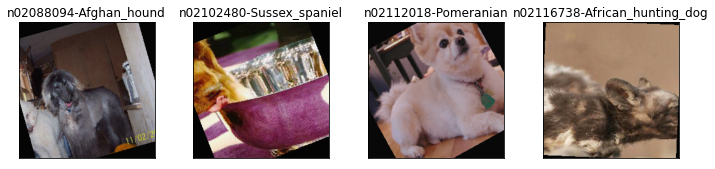

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    image = image.clip(0,1)
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress monitor
---

In [ ]:

from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Finetuning the convnet
---


In [ ]:
# ConvEnsemble 클래스

class ConvEnsemble(nn.Module):
    def __init__(self):
        super().__init__()

        self.model_a = models.resnet50(pretrained=True)
        self.model_b = models.googlenet(pretrained=True)
        self.model_c = models.densenet121(pretrained=True)

        self.fc = nn.Linear(3000, len(classes) )

    def forward(self, x):
        out_a = self.model_a(x)
        out_b = self.model_b(x)
        out_c = self.model_c(x)

        # out_a의 모양은 (N, 1000)
        # out_b의 모양은 (N, 1000)
        # out_c의 모양은 (N, 1000)
        # out_s의 모양은 (N, 3000), 옆으로 길게 이어붙이는 concaternation (연접)
        out_s = torch.cat( (out_a, out_b,out_c), dim=1 ) 

        out = self.fc(out_s)

        return out


In [ ]:
# 앙상블 모델을 선택

# model = models.vgg11(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.densenet121(pretrained=True)

model = ConvEnsemble()

# print(model)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# GPU로 모델 전송
model = model.to(device)

# 손실함수
loss_func = nn.CrossEntropyLoss()

# 최적화 SGD 사용
optimizer_ft = optim.SGD( model.parameters(), lr=learning_rate, momentum=0.9 )

# LR Scheduler 사용
# 매 7 epoch 마다 기존 학습률에 0.1을 곱해주는 방식으로 학습률이 점점 작아지게
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### Train/test
---

In [ ]:
def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    correct_train = 0

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

        # accumulate correct count
        preds = torch.argmax(output, 1)
        correct_train += (preds == target).sum().item()


    # update learning rate scheduler
    if scheduler:
        scheduler.step()

    # Calculate train accuracy    
    acc = 100 * correct_train / len(train_dataset) 
    print( 'Train acc: {}/{} ({:.2f}%)'.format( correct_train, len(train_dataset), acc ) )

    return acc
        
        

In [ ]:
def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [ ]:
since = time.time()

# 현재 모델의 가중치 저장
best_model_weights = copy.deepcopy( model.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model)

    # 지금까지보다 더 좋은 성능이 나온 가중치라면 저장
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model.state_dict() )

# 최고 성능 가중치 로드
model.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))



Epoch: 1/5 Loss: 5.1612 2061 / 2061,2061


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train acc: 380/2061 (18.44%)
Test Acc: 81/480 (16.88%)


Epoch: 2/5 Loss: 2.9093 64 / 2061,64


KeyboardInterrupt: ignored